In [1]:
import pandas as pd

In [6]:
df = pd.read_csv('OnlineRetail.csv', encoding='ISO-8859-1')
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [7]:
df.dropna(subset=['CustomerID'], inplace=True)
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [8]:
clv_df = df.groupby('CustomerID').agg({
    'TotalAmount': 'sum',
    'InvoiceNo': 'nunique'
}).rename(columns={
    'TotalAmount': 'CLV',
    'InvoiceNo': 'TotalOrders'
})
clv_df['AvgOrderValue'] = clv_df['CLV'] / clv_df['TotalOrders']
clv_df.sort_values(by='CLV', ascending=False).head()


,CLV,TotalOrders,AvgOrderValue
CustomerID,,,
14646.0,280206.02,74,3786.567838
18102.0,259657.30,60,4327.621667
17450.0,194550.79,46,4229.365000
16446.0,168472.50,2,84236.250000
14911.0,143825.06,201,715.547562


In [9]:
df['Hour'] = df['InvoiceDate'].dt.hour
df['Day'] = df['InvoiceDate'].dt.date
df['Weekday'] = df['InvoiceDate'].dt.day_name()


In [10]:
daily_trend = df.groupby('Day')['TotalAmount'].sum()

In [11]:
hourly_trend = df.groupby('Hour')['TotalAmount'].sum()

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

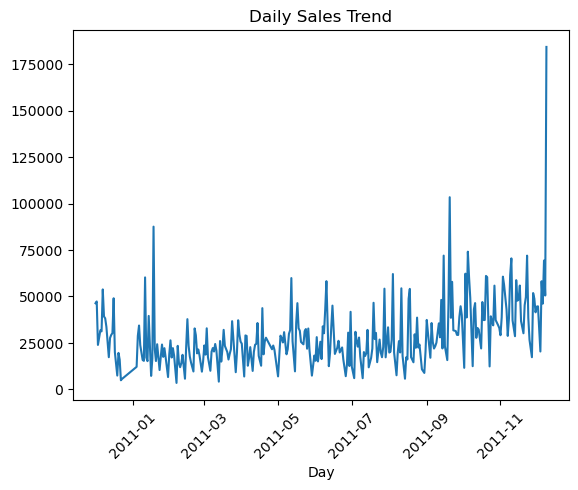

In [13]:
sns.lineplot(x=daily_trend.index, y=daily_trend.values)
plt.title('Daily Sales Trend')
plt.xticks(rotation=45)
plt.show()

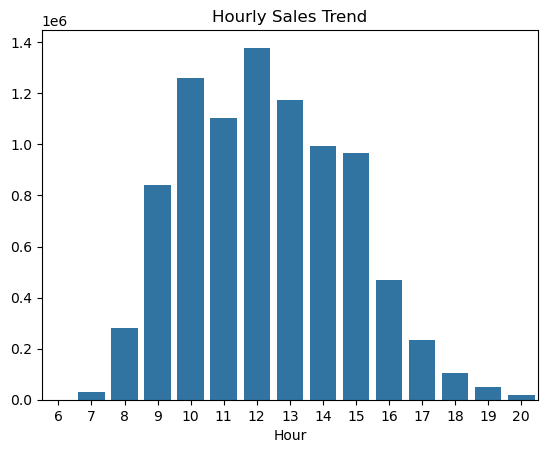

In [14]:
sns.barplot(x=hourly_trend.index, y=hourly_trend.values)
plt.title('Hourly Sales Trend')
plt.show()

In [16]:
!pip install mlxtend


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
    --------------------------------------- 0.0/1.4 MB ? eta -:--:--
    --------------------------------------- 0.0/1.4 MB ? eta -:--:--
   -- ------------------------------------- 0.1/1.4 MB 573.4 kB/s eta 0:00:03
   --- ------------------------------------ 0.1/1.4 MB 595.3 kB/s eta 0:00:03
   --- ------------------------------------ 0.1/1.4 MB 595.3 kB/s eta 0:00:03
   --- ------------------------------------ 0.1/1.4 MB 595.3 kB/s eta 0:00:03
   ----- ---------------------------------- 0.2/1.4 MB 523.5 kB/s eta 0:00:03
   ----- ---------------------------------- 0.2/1

In [17]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

In [18]:
basket = df.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().fillna(0)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

C:\Users\loges\AppData\Local\Temp\ipykernel_8632\3791120194.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)


In [19]:
frequent_items = apriori(basket, min_support=0.02, use_colnames=True)
rules = association_rules(frequent_items, metric='lift', min_threshold=1.0)
rules.sort_values('confidence', ascending=False).head()

C:\Users\loges\AppData\Roaming\Python\Python312\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
72,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.023522,0.037279,0.021040,0.894495,23.994742,1.0,0.020163,9.124923,0.981409,0.529172,0.890410,0.729447
70,"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",(ROSES REGENCY TEACUP AND SAUCER ),0.024817,0.042242,0.021040,0.847826,20.070631,1.0,0.019992,6.293837,0.974356,0.457210,0.841114,0.672955
8,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.029996,0.037279,0.024817,0.827338,22.193256,1.0,0.023698,5.575760,0.984471,0.584498,0.820652,0.746520
62,(PINK REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.029996,0.042242,0.023522,0.784173,18.563760,1.0,0.022255,4.437611,0.975389,0.482835,0.774654,0.670503
12,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.037279,0.042242,0.029186,0.782923,18.534184,1.0,0.027612,4.412071,0.982679,0.579850,0.773349,0.736928
